In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
def hist_equ(input_image):
    # number of pixel
    N = input_image.shape[0] * input_image.shape[1]
    # histogram
    input_hist, _ = np.histogram(input_image.flatten(), 256, [0, 256])
    input_hist = input_hist/N
    # cumulative histogram
    cdf = input_hist.cumsum() #implicitly converted to float64
    # histogram equalization
    output_image = np.zeros(input_image.shape, dtype=input_image.dtype)
    output_image = 255 * cdf[input_image]
    output_image = output_image.astype(np.uint8)
    output_hist, _ = np.histogram(output_image.flatten(), 256, [0, 256])
    output_hist = output_hist/N
    return (output_image, output_hist, input_hist)

This is a (500, 500) image, with datatype uint8


C:\Users\Tangent\AppData\Local\Temp\ipykernel_23160\3172195416.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


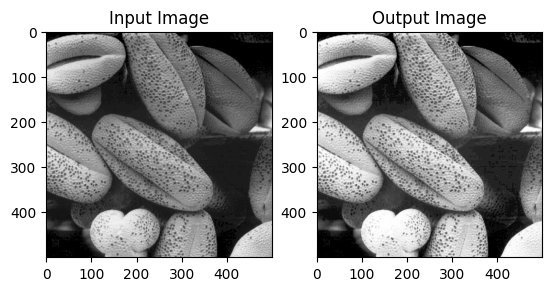

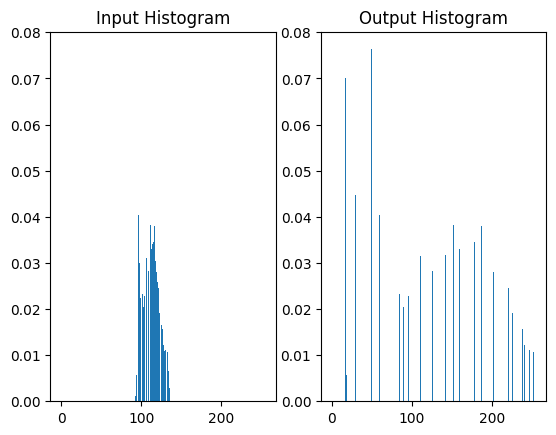

In [48]:
if __name__ == "__main__":
    # Read image
    test1 = plt.imread('in/Q3_1_1.tif')
    plt.imshow(test1, cmap='gray')
    print(f"This is a {test1.shape} image, with datatype {test1.dtype}")

    arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
    plt.bar(np.array([1,2,3,4,5,6,7,8,9]),arr)

    # Histogram equalization
    output_image, output_hist, input_hist = hist_equ(test1)
    plt.subplot(1,2,1)
    plt.imshow(test1, cmap='gray')
    plt.title('Input Image')
    plt.subplot(1,2,2)
    plt.imshow(output_image, cmap='gray')
    plt.title('Output Image')
    plt.show()

    plt.subplot(1,2,1)
    plt.bar(np.arange(256), input_hist)
    plt.title('Input Histogram')
    plt.subplot(1,2,2)
    plt.bar(np.arange(256), output_hist)
    plt.title('Output Histogram')
    plt.show()

    img = Image.fromarray(output_image)
    Image.fromarray(output_image).save('out/Q3_1_1_output.jpg')